In [2]:
# --- Setup: Add project root to Python path ---
import sys, os

# Add project root to system path for local imports (if not already included)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# --- Import core modules for ChartAlignBench demo ---

# VLM model wrappers for inference (defined in utils/vlm_inference_helper.py)
# Default setup uses transformers==4.42.0
from utils.vlm_inference_helper import Phi35, LlaVa16, InternVL25   

# Alternative: Uncomment the Qwen model for evaluation
# Note: requires transformers >= 4.50.0
# from utils.qwen_inference_helper import Qwen25                    

# Predefined prompt templates used to query VLMs for specific grounding/alignment tasks
from utils.prompt_templates import PROMPT_TEMPLATES

# Utility functions for handling model inputs and outputs
from utils.process_vlm_io import process_pred_csv, get_chart_pair_images, data_alignment_str_to_json, process_attr_alignment_response

# Evaluation functions for computing grounding and alignment metrics
from utils.evaluation_metrics import compute_grounding_metrics, compute_alignment_score

# Visualization utilities for displaying charts and results interactively
from utils.show_results import show_chart_grounding, show_chart_alignment

/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
from datasets import load_dataset

# dataset subset for performing Attribute Grounding & Alignment
dataset = load_dataset("umd-zhou-lab/ChartAlignBench", "attribute_grounding_and_alignment")["test"]

# Among attributes (color/legend/text style), we evaluate "text style" in current notebook
text_style_difference_examples = dataset.filter(lambda example: example["attribute"] == "text_style")

In [4]:
sample_idx = 18

# select sample from dataset to perform the demo
sample = text_style_difference_examples[sample_idx]
sample

{'idx': 154,
 'imgname': 'bar_107',
 'chart_type': 'bar_chart',
 'attribute': 'text_style',
 'chart_1_grounding': '{"chart title": {"size": 14, "weight": "normal", "fontfamily": "sans-serif"}, "chart legend": {"size": 12, "weight": "normal", "fontfamily": "sans-serif"}, "chart axes labels": {"size": 12, "weight": "normal", "fontfamily": "sans-serif"}, "chart axes ticks": {"size": 12, "weight": "normal", "fontfamily": "sans-serif"}}',
 'chart_2_grounding': '{"chart title": {"size": 14, "weight": "bold", "fontfamily": "serif"}, "chart legend": {"size": 16, "weight": "normal", "fontfamily": "serif"}, "chart axes labels": {"size": 18, "weight": "light", "fontfamily": "serif"}, "chart axes ticks": {"size": 22, "weight": "normal", "fontfamily": "serif"}}',
 'alignment_json': '{"chart title": {"weight": {"initial value": "normal", "modified value": "bold"}, "fontfamily": {"initial value": "sans-serif", "modified value": "serif"}}, "chart legend": {"size": {"initial value": 12, "modified value

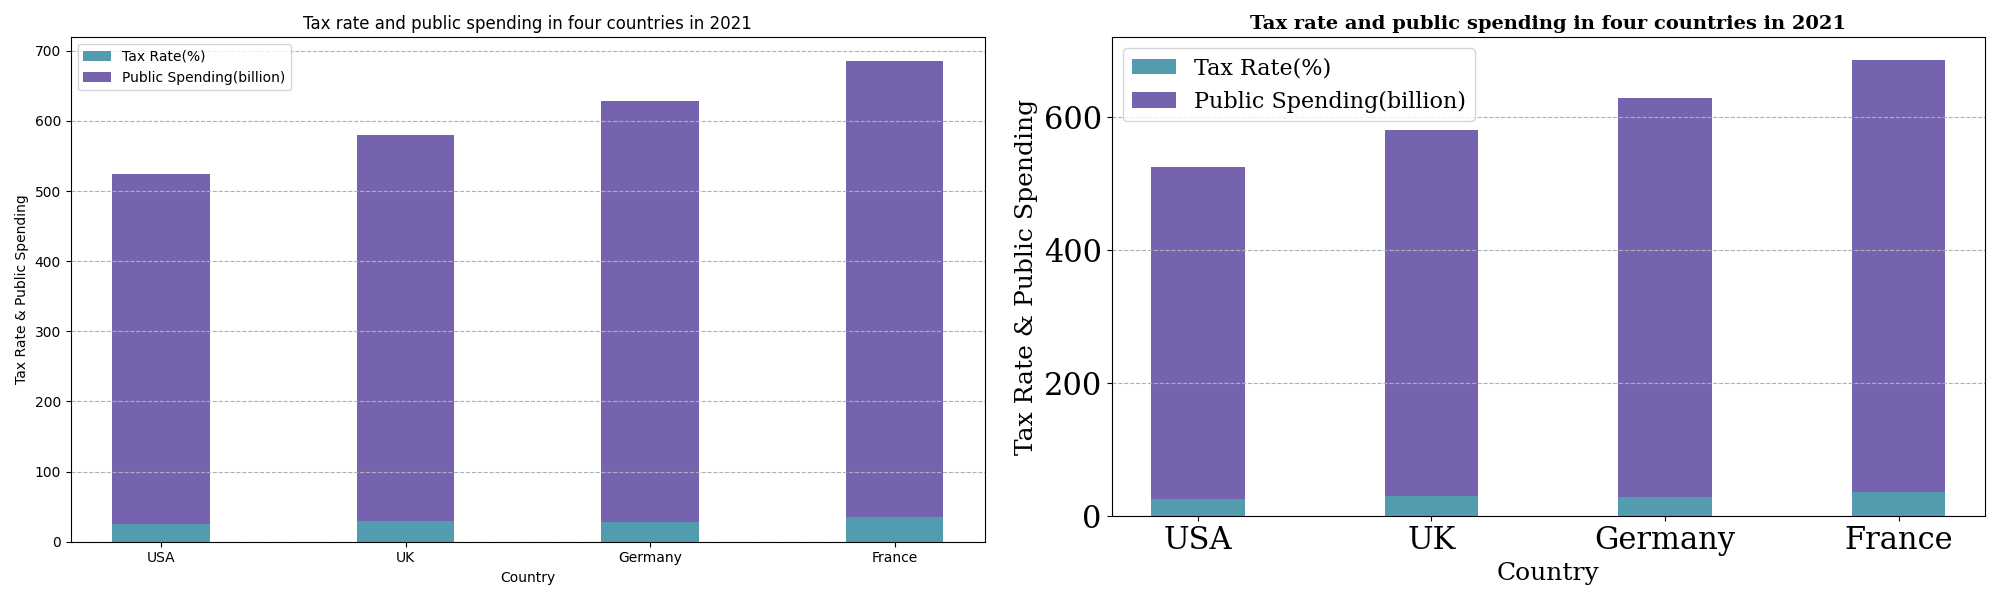

In [5]:
# image pair (pair of images stitched horizontally)
img = sample["image_pair"]

# individual chart images
chart_1_img, chart_2_img = get_chart_pair_images(img)
img

In [6]:
VLM_obj = Phi35()

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- configuration_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- modeling_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3.5-vision-instruct:
- processing_phi3_v.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/cmlscratch/ani01/.conda/miniconda/envs/phi_3/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:510: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Text Style Grounding

In this section, we evaluate VLMs ability to correctly ground *text style* characteristics (text size, text weight - lightness/boldness, text font) for different regions (title, legend, axes labels, axes ticks) of the chart.


In [7]:
import json

# --- TEXT STYLE Grounding Evaluation ---

# Retrieve the predefined prompt template for color grounding
text_style_grounding_prompt = PROMPT_TEMPLATES["attribute"]["text_style"]["grounding"]

# Grounding for Chart-1
chart_1_pred_grounding = VLM_obj.infer(
    prompt_text_template=text_style_grounding_prompt,  # query for grounding task
    images_list=[chart_1_img]                      # single chart input
).replace("json", "").replace("```", "")        # format output

# Grounding for Chart-2
chart_2_pred_grounding = VLM_obj.infer(
    prompt_text_template=text_style_grounding_prompt,  
    images_list=[chart_2_img]                      
).replace("json", "").replace("```", "")        

# Ground truth for Grounding
chart_1_gt_grounding = json.loads(sample['chart_1_grounding'])
chart_2_gt_grounding = json.loads(sample['chart_2_grounding'])

# Evaluating grounding prediction
chart_1_grounding_score = compute_grounding_metrics(chart_1_gt_grounding, json.loads(chart_1_pred_grounding), "text_style")
chart_2_grounding_score = compute_grounding_metrics(chart_2_gt_grounding, json.loads(chart_2_pred_grounding), "text_style")

The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.



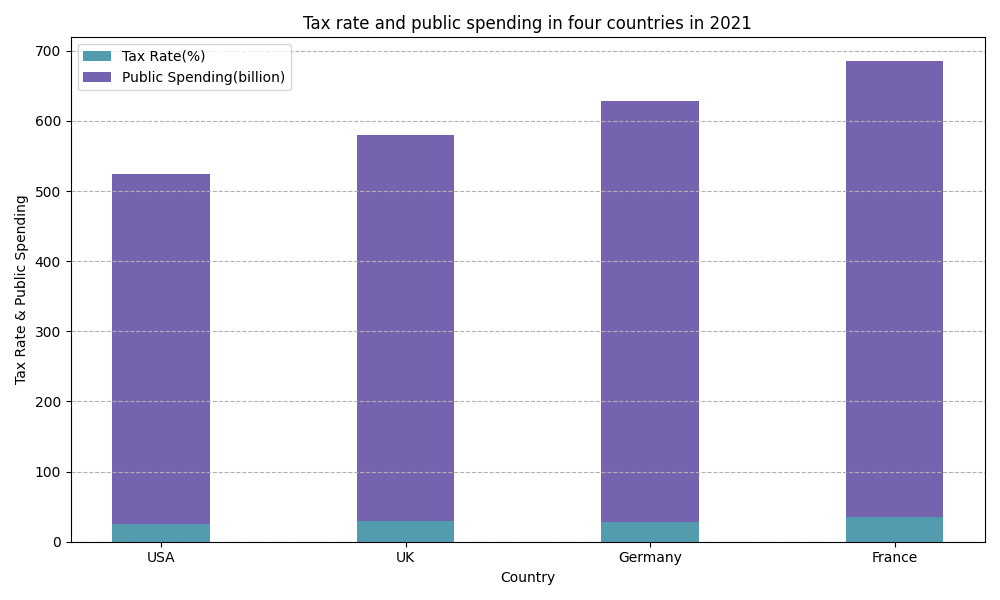
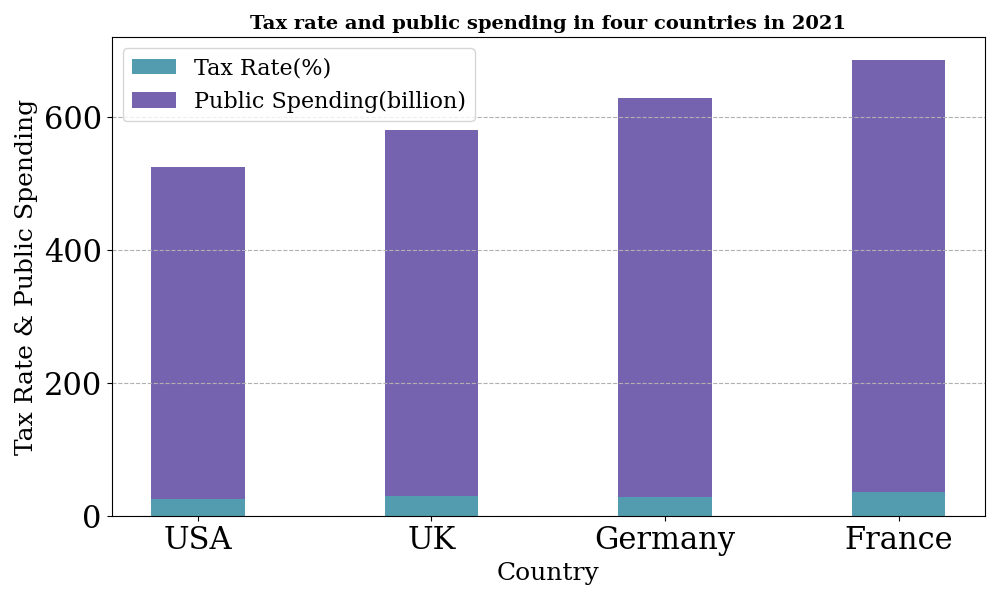

In [8]:

# --- Visualize grounding results ---

show_chart_grounding(
    chart_1_img,                # first chart image (e.g., reference chart)
    chart_2_img,                # second chart image (e.g., modified chart)
    chart_1_gt_grounding,       # ground-truth grounding annotations for chart 1
    chart_1_pred_grounding,     # model-predicted grounding for chart 1
    chart_2_gt_grounding,       # ground-truth grounding annotations for chart 2
    chart_2_pred_grounding,     # model-predicted grounding for chart 2
    chart_1_grounding_score,    # evaluation metric(s) for chart 1
    chart_2_grounding_score,    # evaluation metric(s) for chart 2
    content_type="text_style"         # type of grounding task ("text_style" for current notebook)
)


### Text Style Alignment

In this section, we evaluate VLMs **text style alignment**, i.e., ability to find difference in text style characteristics (size/weight/font) for text regions betwen the chart images.

In [9]:
# Get the predefined alignment prompt template for text style alignment
text_style_alignment_prompt = PROMPT_TEMPLATES["attribute"]["text_style"]["alignment"]

# Inject predicted grounding results of both charts into the alignment prompt
# These grounding results provide context for subsequent alignment of chart pair
text_style_alignment_prompt = text_style_alignment_prompt.replace("image_1_predicted_grounding_tag", chart_1_pred_grounding)
text_style_alignment_prompt = text_style_alignment_prompt.replace("image_2_predicted_grounding_tag", chart_2_pred_grounding)

# Run inference with the constructed prompt and parse model output to JSON
pred_alignment_json = process_attr_alignment_response(VLM_obj.infer(prompt_text_template = text_style_alignment_prompt), "text_style")
gt_alignment_json = json.loads(sample['alignment_json'])



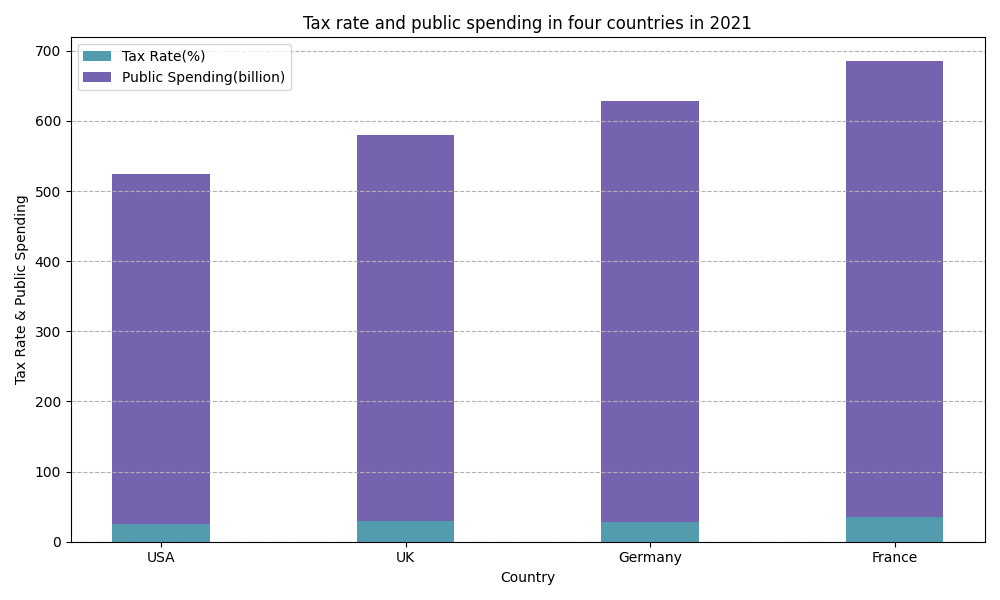
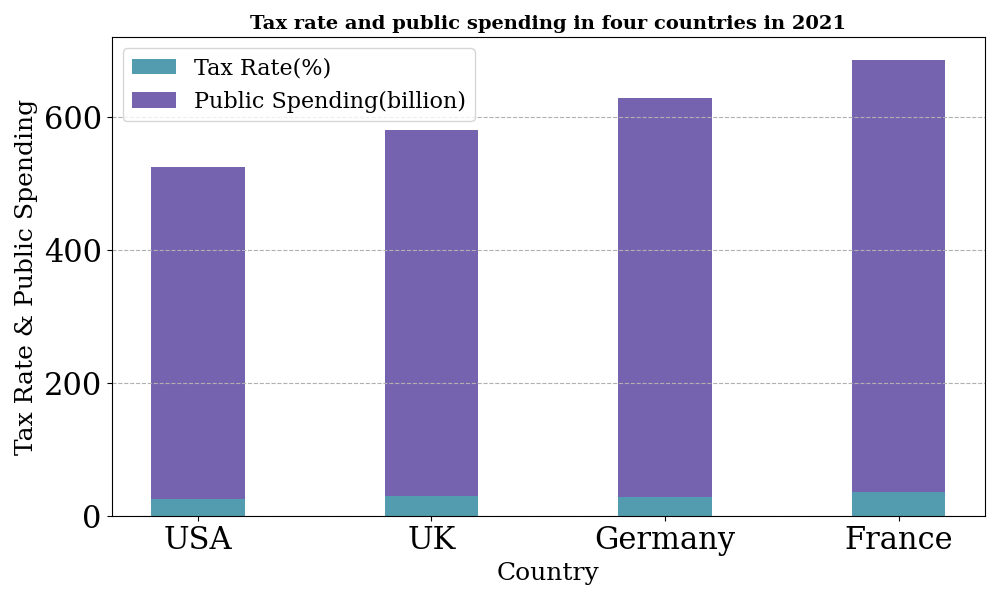

In [10]:
# --- Compute alignment score ---

# Precision of predicted v/s ground-truth JSON for the alignment task
alignment_score = compute_alignment_score(gt_alignment_json, json.loads(pred_alignment_json), "text_style")

# --- Visualize alignment results ---

show_chart_alignment(
    chart_1_img,            # first chart image 
    chart_2_img,            # second chart image 
    gt_alignment_json,      # ground-truth alignment annotations
    pred_alignment_json,    # model-predicted alignment JSON
    alignment_score         # computed alignment metric(s)
)